# First, import data

In [1]:
import os
import numpy as np
import tifffile

ModuleNotFoundError: No module named 'tifffile'

In [77]:
# Open video for reading

# v_fname = '/users/charles.fieseler/DeepLabCut-dev/DeepLabCut/examples/WormTest-Charlie-2020-07-09/videos/test_100frames_13slice.avi'
folder_name = '/groups/zimmer/Ulises/wbfm/wbfm_december2018/20181220/data/worm1/mCherry/ome/'
all_fnames = os.listdir(folder_name)
all_fnames = sorted(all_fnames)[1:]

which_slice = 15

full_fname = os.path.join(folder_name,all_fnames[0])
im1 = tifffile.imread(full_fname)[which_slice,...]

full_fname = os.path.join(folder_name,all_fnames[1])
im2 = tifffile.imread(full_fname)[which_slice,...]
    
# Convert to uint8
to_uint8 = lambda f : ((f-np.min(f))/np.max(f)*255.0).astype('uint8')

im1 = to_uint8(im1)
im2 = to_uint8(im2)
# im1 = im1.astype('float32')
# im2 = im2.astype('float32')

In [78]:
im1.shape

(650, 850)

In [130]:
# FROM LUKAS
# The whole filter procedure as function:
# The image has to be square
# Option for the future: add pixel on the smaller side to make it square and crop after filtering
def filterImage(filterImg, highFrequ, lowFrequ):
    (x, y) = filterImg.shape
    if x != y:
        print('Error: Image is not quadratic!')
        return -1
    # set filter values
    rhigh = highFrequ # how narrower the window is
    rlow = lowFrequ
    ham = np.hamming(x)[:,None] # 1D hamming
    ham2dhigh = np.sqrt(np.dot(ham, ham.T)) ** rhigh # expand to 2D hamming
    ham2dlow = np.sqrt(np.dot(ham, ham.T)) ** rlow
    ham2d = ham2dhigh - ham2dlow
    # check if image is square
    # calculate fourier transform
    f = cv2.dft(filterImg.astype('float32'), flags=cv2.DFT_COMPLEX_OUTPUT)
    # reorder result quarters
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    # apply filter mask
    f_filtered = ham2d * f_complex
    # reorder result
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    return filtered_img

# Try 1: Use ECC for alignment

Following:
https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

In [64]:
import cv2
import matplotlib.pyplot as plt
import timeit

In [16]:
# From: https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

# Convert images to grayscale
# im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
# im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

im1_gray = im1.astype('float32')
im2_gray = im2.astype('float32')

# Find size of image1
sz = im1.shape

# Define the motion model
# warp_mode = cv2.MOTION_EUCLIDEAN
warp_mode = cv2.MOTION_AFFINE

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 5000;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

In [18]:
start = timeit.timeit()

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

end = timeit.timeit()
print("Time elapsed: ", end - start)

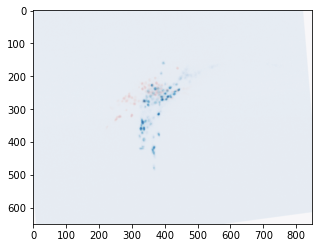

In [26]:
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

# Show final results
fig, axis = plt.subplots(figsize=(5, 5))
axis.imshow(im1, cmap='Reds', alpha=0.8)
axis.imshow(im2_aligned, cmap='Blues', alpha=0.8)
# plt.figure(figsize=(25,25))
# plt.subplot(131)
# plt.imshow(im1)
# plt.subplot(132)
# plt.imshow(im2)
# plt.subplot(133)
# plt.imshow(im2_aligned)
# cv2.waitKey(0)

# Try 2: Feature-based alignment

Following:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

In [79]:
import cv2
import numpy as np
import timeit
from skimage import transform
import matplotlib.pyplot as plt

In [162]:
MAX_FEATURES = 3000
GOOD_MATCH_PERCENT = 0.10

In [163]:
def convert_to_grayscale(im1, im2):
    try:
        im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
        im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    except:
        im1Gray = im1
        im2Gray = im2
    
    return im1Gray, im2Gray


def detect_features_and_match(im1, im1Gray, im2, im2Gray):
    
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    
    return keypoints1, keypoints2, matches


def extract_location_of_matches(matches, keypoints1, keypoints2):
    
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    return points1, points2

In [172]:
def alignImages(im1, im2, use_skimage=True):
    """
    Aligns two images using orb-generated features
    
    Args:
        im1: numpy image in XY or XYC (color optional)
        
        im2: same format as im1
    """
    
    # Convert images to grayscale
    im1Gray, im2Gray = convert_to_grayscale(im1, im2)

    # Features
    keypoints1, keypoints2, matches = detect_features_and_match(im1, im1Gray, im2, im2Gray)

    # Extract location of good matches
    points1, points2 = extract_location_of_matches(matches, keypoints1, keypoints2)

    # Find homography
#     h, mask = cv2.estimateAffine2D(points1, points2)
    if use_skimage:
        h = transform.estimate_transform('euclidean', points1, points2)
    else:
        h, mask = cv2.estimateAffinePartial2D(points1, points2)

    # Use homography
    # Only width and height, removing color channels if any
    if use_skimage:
        im1Reg = transform.warp(im1, inverse_map=h.inverse) 
#         im1Reg = None
    else:
        im1Reg = cv2.warpAffine(im1, h, im2.shape[:2])

    return im1Reg, h, keypoints1, keypoints2, matches

# Compare feature-based algorithms

In [173]:
start = timeit.timeit()

im1Reg_cv2, h, keypoints1, keypoints2, matches = alignImages(im1, im2, False)

end = timeit.timeit()
print("Time elapsed: ", end - start)

Time elapsed:  -0.0005893469788134098


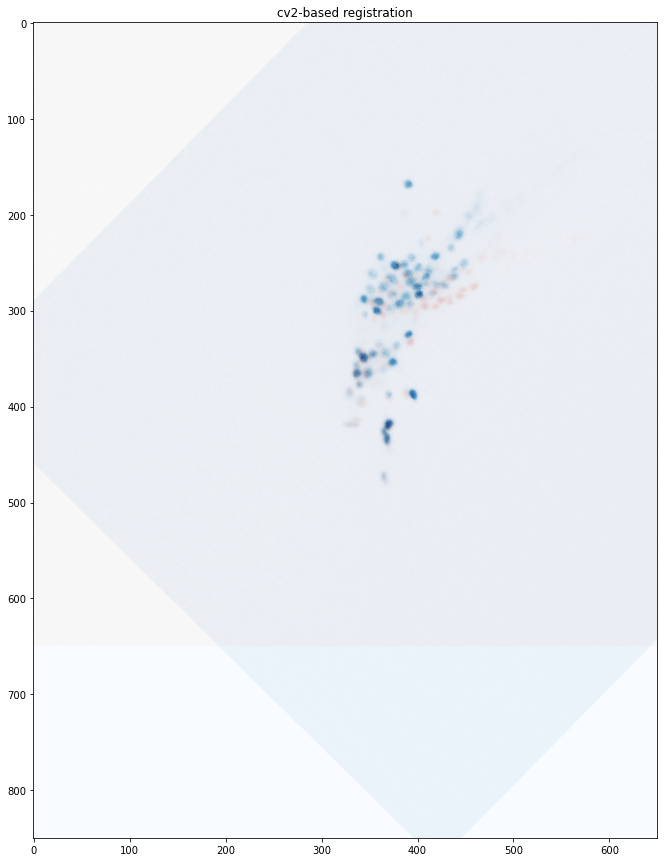

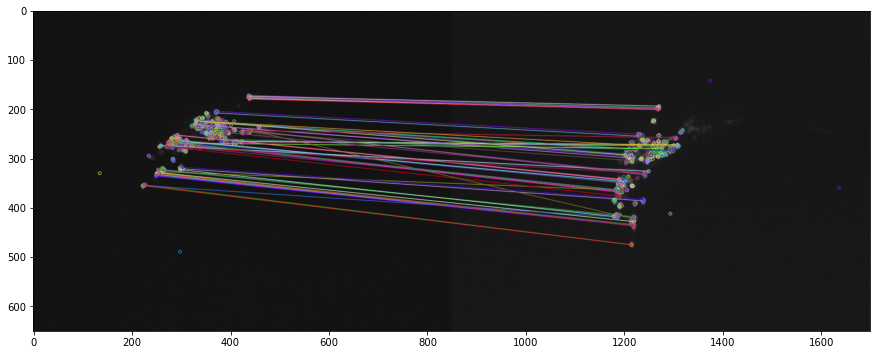

In [174]:
fig, axis = plt.subplots(figsize=(15, 15))
axis.imshow(im2, cmap='Reds', alpha=0.8)
axis.imshow(im1Reg_cv2, cmap='Blues', alpha=0.8)
plt.title("cv2-based registration")

imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
fig, axis = plt.subplots(figsize=(15, 15))

plt.imshow(imMatches)

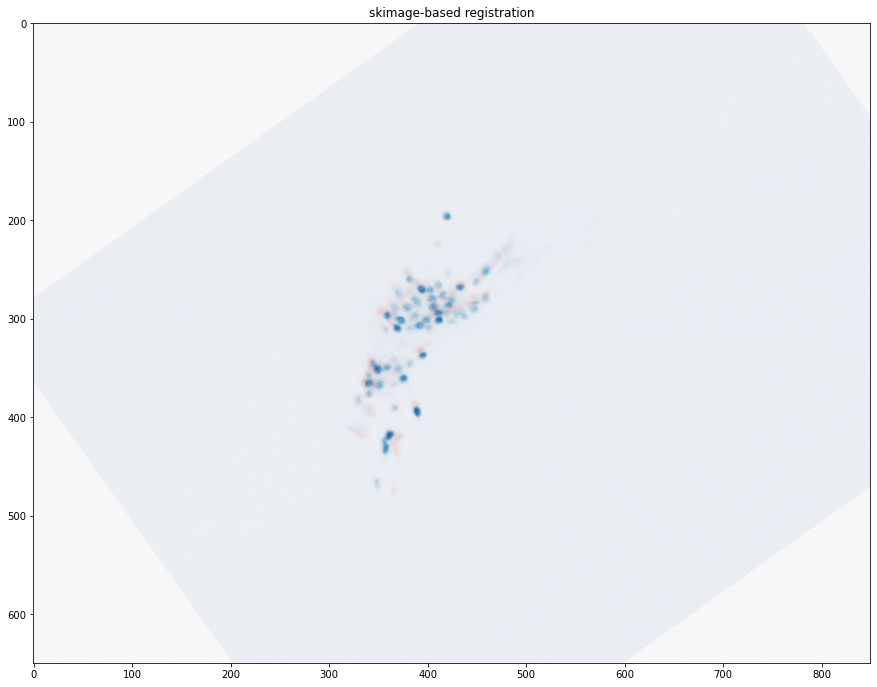

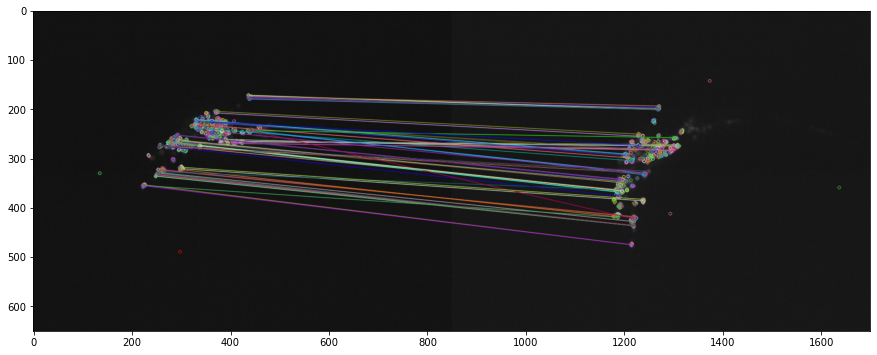

In [175]:
# Now do skimage
im1Reg_skimage, h, keypoints1, keypoints2, matches = alignImages(im1, im2)

fig, axis = plt.subplots(figsize=(15, 15))
axis.imshow(im2, cmap='Reds', alpha=0.8)
axis.imshow(im1Reg_skimage, cmap='Blues', alpha=0.8)
plt.title("skimage-based registration")

imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
fig, axis = plt.subplots(figsize=(15, 15))

plt.imshow(imMatches)

# Align a video

In [176]:
def align_video(all_fnames, which_slice=15, num_frames=10, ref_frame=0, use_skimage=True):
    
    to_uint8 = lambda f : ((f-np.min(f))/np.max(f)*255.0).astype('uint8')
    filt = lambda img : to_uint8(cv2.bilateralFilter(img.astype('float32'), d=9, sigmaColor=50, sigmaSpace=3)) 

    # Get reference frame
    full_fname = os.path.join(folder_name,all_fnames[ref_frame])
    im_reference = filt(tifffile.imread(full_fname)[which_slice,...])

    registered_frames = []
    # Read other frames and register them
    for i in range(num_frames):
        if i==ref_frame:
            continue
        print(f'Analyzing frame {i} / {num_frames-1}')
        
        full_fname = os.path.join(folder_name,all_fnames[i])
        im1 = filt(tifffile.imread(full_fname)[which_slice,...])
    
        imReg, _,_,_,_ = alignImages(im1, im_reference, use_skimage)
        
        registered_frames.append(imReg)
    
    print("Finished Analyzing")
    
    return registered_frames, im_reference


In [180]:
folder_name = '/groups/zimmer/Ulises/wbfm/wbfm_december2018/20181220/data/worm1/mCherry/ome/'
all_fnames = os.listdir(folder_name)
all_fnames = sorted(all_fnames)[1:]

reg_frames, im_reference = align_video(all_fnames, use_skimage=True)

Analyzing frame 1 / 9
Analyzing frame 2 / 9
Analyzing frame 3 / 9
Analyzing frame 4 / 9
Analyzing frame 5 / 9
Analyzing frame 6 / 9
Analyzing frame 7 / 9
Analyzing frame 8 / 9
Analyzing frame 9 / 9
Finished Analyzing


In [181]:
def interactive_plotter(reg_frames, im_reference, i=0):
    fig, axis = plt.subplots(figsize=(15, 15))
    axis.imshow(im_reference, cmap='Reds', alpha=0.8)
    axis.imshow(reg_frames[i], cmap='Blues', alpha=0.8)
    plt.title(f"Reference frame {i}")
    plt.show()
from ipywidgets import interact, interactive, fixed, interact_manual


In [182]:
f = lambda i : interactive_plotter(reg_frames, im_reference, i)
interact(f, i=(0,len(reg_frames)-1))

interactive(children=(IntSlider(value=4, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

# Try 3: NormCorre

In [1]:

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
import time
import logging

/users/charles.fieseler/.conda/envs/DLC-preprocessing/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/charles.fieseler/.conda/envs/DLC-preprocessing/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/charles.fieseler/.conda/envs/DLC-preprocessing/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [2]:

fnames = '/users/charles.fieseler/test_worm1_data/mCherry/test_100frames_13slice.ome.tiff'
# m_orig = cm.load_movie_chain(fnames)
downsample_ratio = .2  # motion can be perceived better when downsampling in time
# m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

In [3]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
num_frames_split = 100  # length in frames of each chunk of the movie (to be processed in parallel)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

In [4]:
# create a motion correction object
mc = MotionCorrect(fnames, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

In [5]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


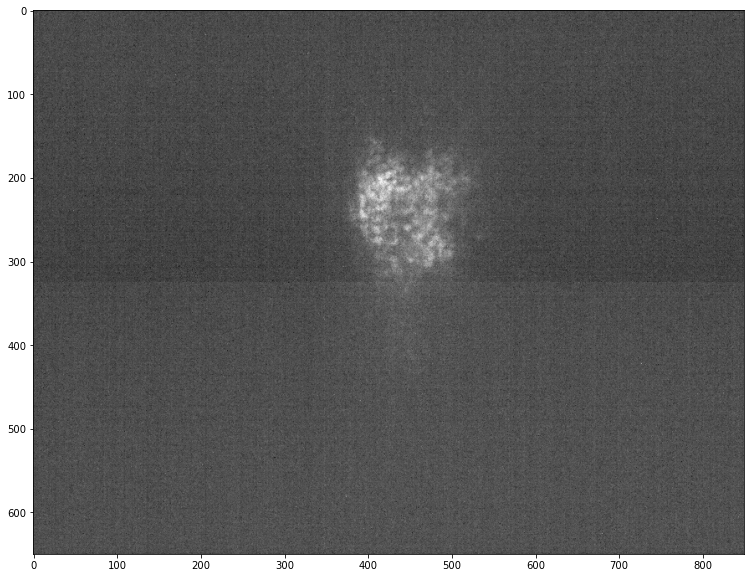

In [6]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
#%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray')

In [ ]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit